In [75]:
import numpy as np
import json
import itertools
import spglib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def write_group(f, members, name):
    # tiling code needs to be updated for more than 2D
    result = {'name': name, 'size': len(members), 'members': []}
    
    has_identity = False
    for m in members:
        # skip extra identities
        if np.allclose(np.eye(m.shape[0]), m):
            if not has_identity:
                has_identity = True
            else:
                continue
        if not has_identity:
            raise ValueError('Must start with identity')
        i = np.linalg.inv(m)
        # tiling meaning inner Ndim x Ndim is diag only and last column is non-zero
        # TODO: which one?
        diag = np.isclose(np.sum(m[:-1, :-1]**2), np.trace(m[:-1, :-1]**2))
        #diag = np.allclose(np.diag(m), np.ones(m.shape[0]))
        tiling = bool(not np.isclose(np.sum(m[:-1,-1]**2), 0) and diag)
        result['members'].append({'g': list(np.round(m.flatten(), 8)), 'i': list(np.round(i.flatten(), 8)), 't': tiling})
    # sort them - identity first and tiling last    
    result['members'].sort(
        key = lambda m: int(m['t']))
    json.dump(result, f, indent=True)
    print('Wrote group with', len(members), 'members and', sum([m['t'] for m in result['members']]), 'tilings')

In [35]:
def str2mat(s):
    rows = []
    N = len(s.split(','))
    env = {'x': np.array([1,0]), 'y': np.array([0,1])}
    fake_env = {'x': 0, 'y': 0}
    for si in s.split(','):
        r = [0] * N
        l = {}
        # use fake ones to get translation
        exec('f = ' + si.strip(), fake_env, l)
        exec('o = ' + si.strip(),env, l)
        # remove trans and add
        rows.append(np.append(l['o'] - l['f'], l['f']))        
    rows.append(np.array([0,0,1]))
    return np.vstack(rows)

def asymm_projector()
str2mat('x/6 - y/6, y + 1/2')

array([[ 0.16666667, -0.16666667,  0.        ],
       [ 0.        ,  1.        ,  0.5       ],
       [ 0.        ,  0.        ,  1.        ]])

In [182]:
#TODO: make it so each input element matters
projectors = {             
    'square': 
    np.array([
        [1/4, 1/4, 1/4, 1/4], 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1/4, 1/4, 1/4, 1/4]
    ]),
    'rectangle': 
    np.array([
        [1/2, 1/2, 0, 0], 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1/2, 1/2]
    ]),
    'hexagon':
    np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [-1/2, 0, 0, 0],
        [np.sqrt(3)/2, 0, 0, 0]
    ]),
    'rhombus':
    np.array([
        [np.sqrt(3) / 2, 0, 0,0],
        [1/2, 0, 0,0],
        [np.sqrt(3) / 2, 0, 0,0],
        [-1/2, 0, 0,0]
    ]),
    'mono':np.eye(4),
}

e = 'x,y'
wallpaper_s = {
    'p1': ('mono', [e], [(0,1), (0,1)]), 
    'p2': ('mono', [e, '-x, y'], [(0,0.5), (0,1)]),
    'pm': ('rectangle', [e, '-x, y + 1/2'], [(0,0.5), (0,1)]),
    'cm': ('rectangle', [e, '-x,y', 'x+1/2,y+1/2', '-x+1/2,y+1/2'], [(0,0.5), (0,0.5)]),
    'pg': ('rectangle', [e, 'x,y', 'x+1/2, y+1/2', '-x+1/2, y+1/2'], [(0,0.5), (0,1)]),
    'pmm': ('rectangle', [e, '-x,-y', '-x,y','x,-y'], [(0,0.5), (0,0.5)]),
    'pmg': ('rectangle', [e, '-x,-y','-x+1/2, y','x+1/2,-y'], [(0,0.25), (0,1)]),
    'pgg': ('rectangle', [e, '-x,-y', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], [(0,0.5), (0,0.5)]),
    'cmm': ('rectangle', [e,'-x,-y', '-x,y', 'x,-y', 'x+1/2,y+1/2',
                       '-x+1/2,-y+1/2', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], [(0,0.25), (0,0.5)]),
    'p4': ('square', [e, '-x,-y', '-y,x', 'y,-x'], [(0,0.5), (0,0.5)]),
    'p4mm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x,y', 'x,-y', 'y,x', '-y,-x'], [(0,0.5), (0,0.5)]),
    'p4gm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x+1/2,y+1/2', 'x+1/2,-y+1/2', 'y+1/2,x+1/2', '-y+1/2,-x+1/2']),
    'p3': ('hexagon', [e,'-y, x-y', '-x+y,-x']),
    'p3m1': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-y,-x', '-x+y,y', 'x,x-y']),
    'p31m': ('hexagon', [e,'-y, x-y', '-x+y,-x', 'y,x', 'x-y,-y', '-x,-x+y']),
    'p6': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x']),
    'p6mm': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x',
                        '-y,-x', '-x+y,y', 'x,x-y', 'y,x', 'x-y,-y', '-x,-x+y']),
    
    
}

wallpaper = {k: (projectors[v[0]], [str2mat(s) for s in v[1]]) for k,v in wallpaper_s.items()}

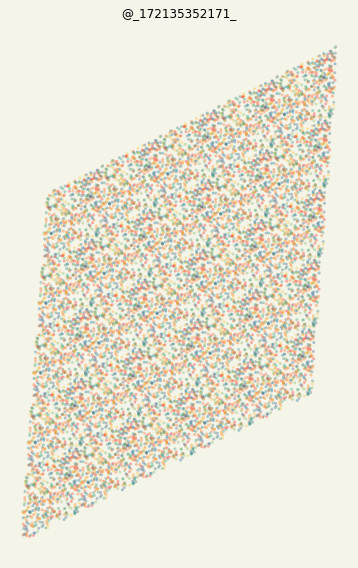

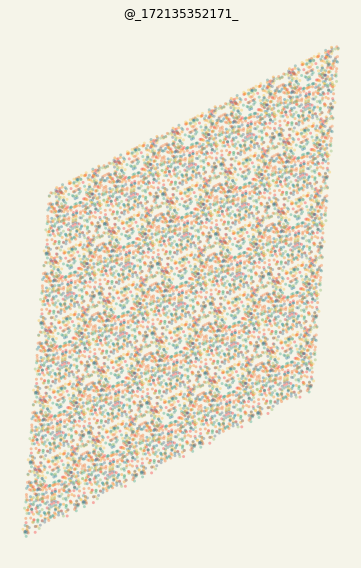

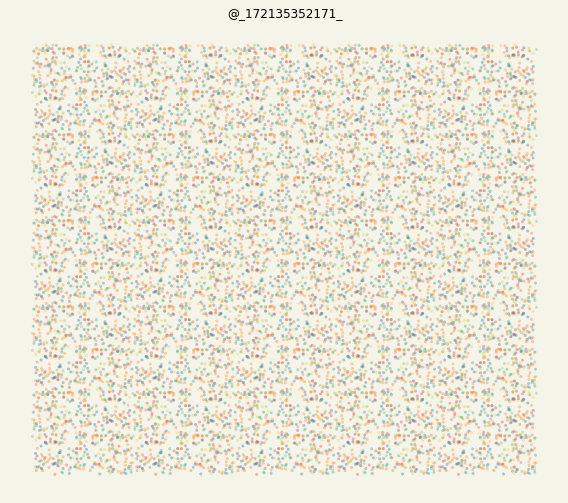

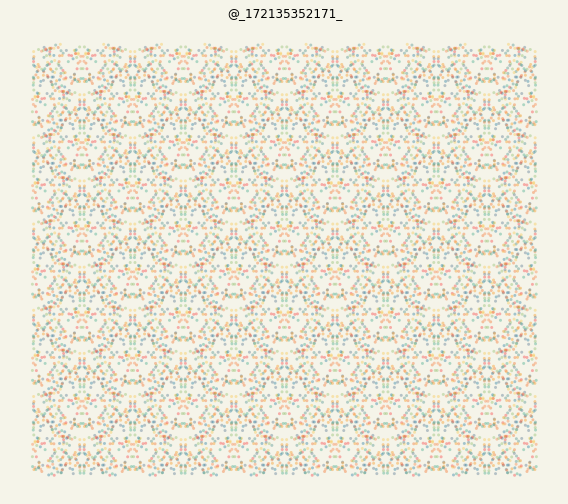

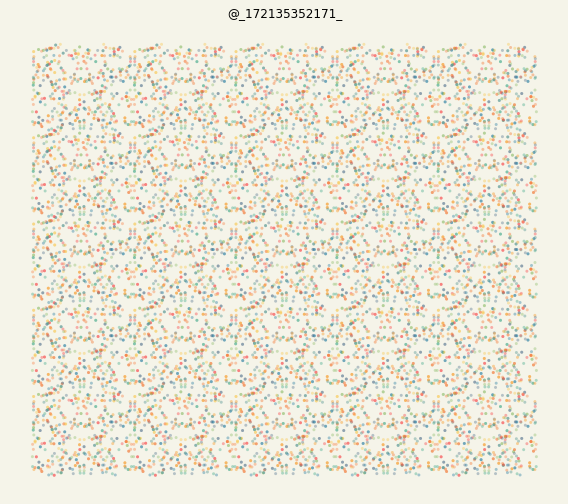

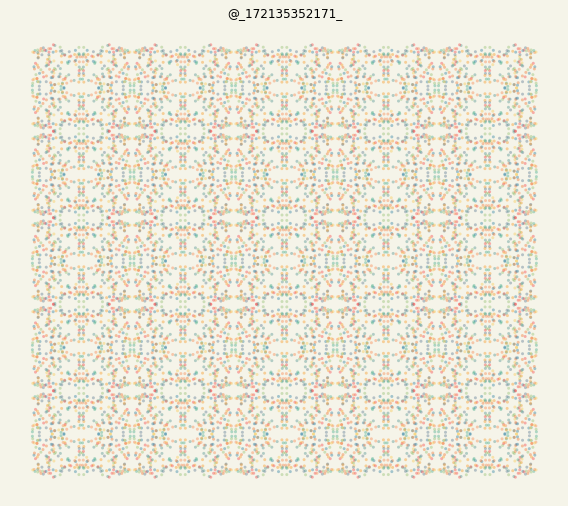

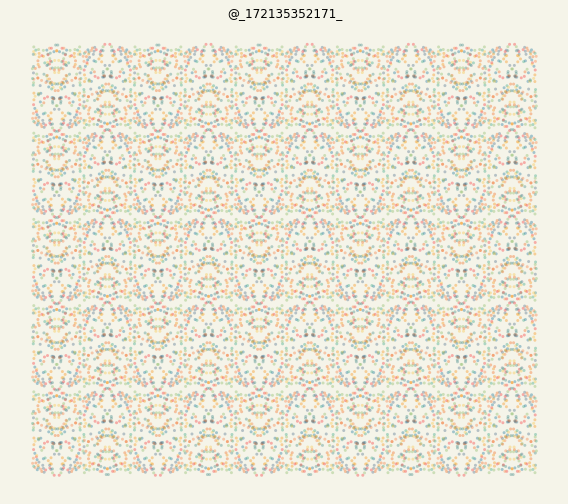

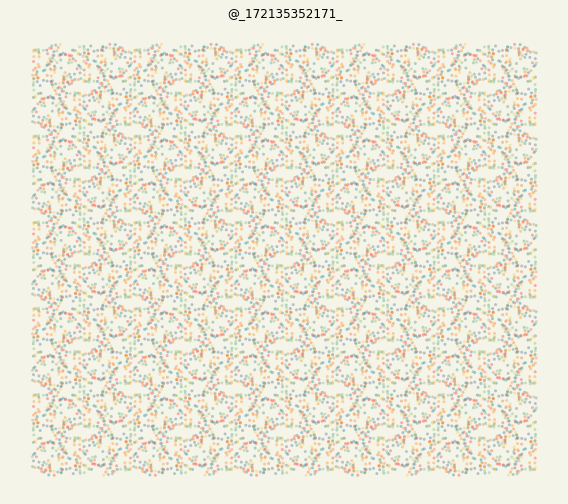

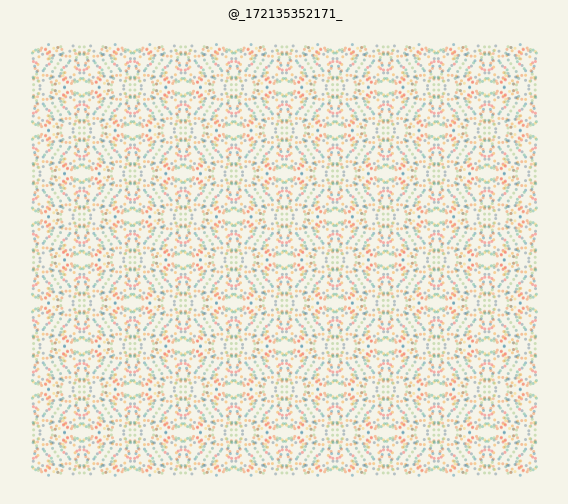

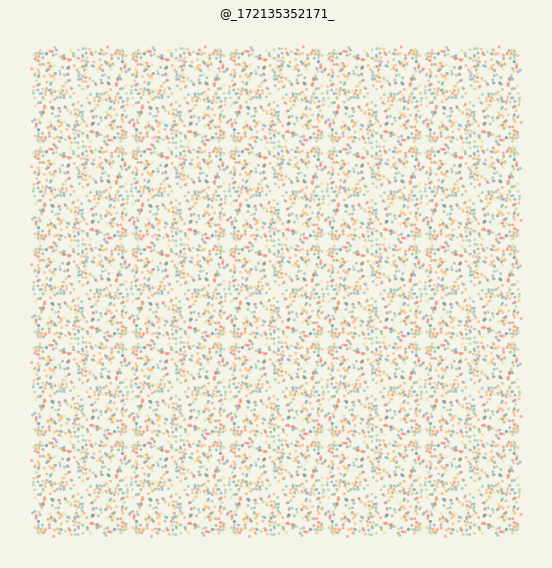

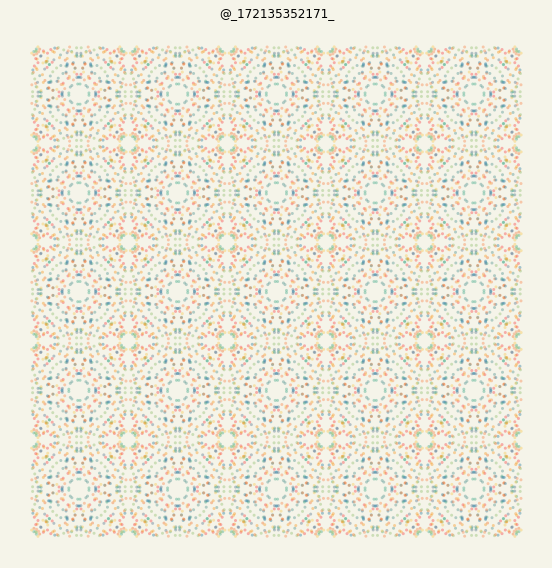

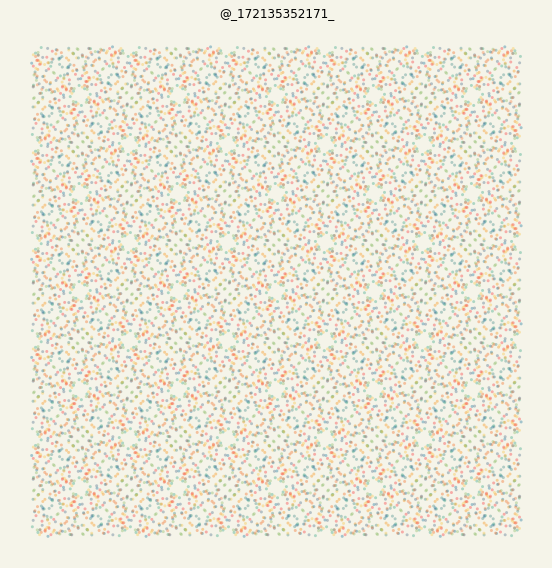

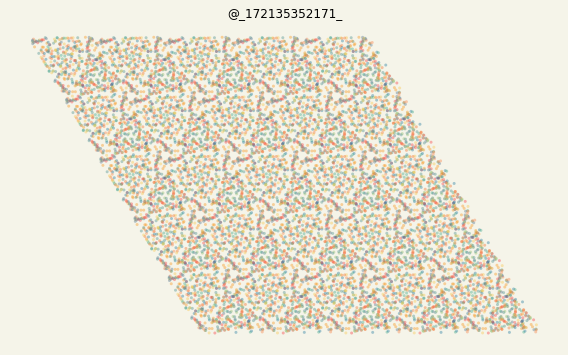

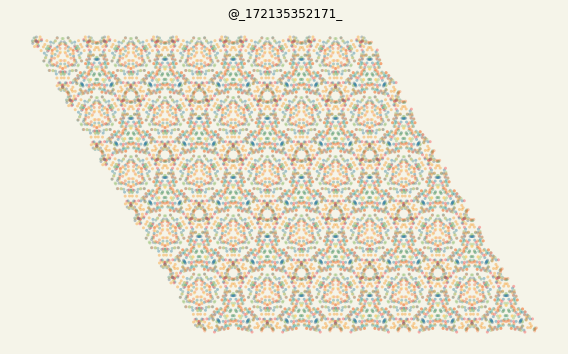

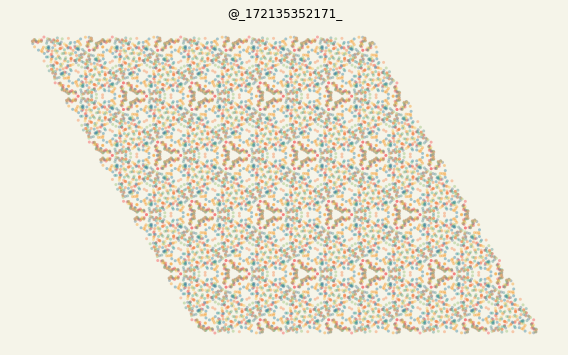

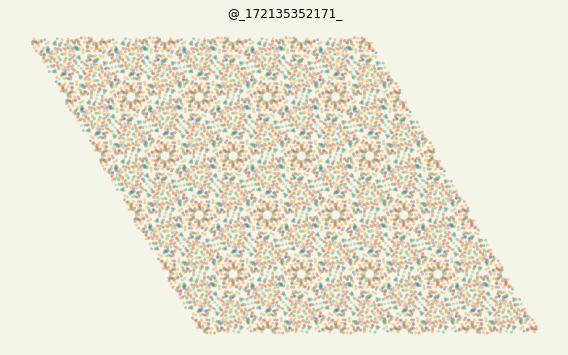

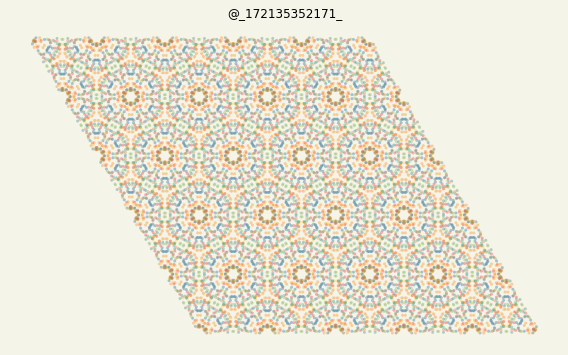

In [187]:
def plot_group(x, basis, g, title, show_basis=False):    
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    if show_basis:
        plt.plot([0, basis[0,0]], [0,basis[0,1]], '-', color='black')
        plt.plot([0, basis[1,0]], [0,basis[1,1]], '-', color='black')
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]    
    points = []
    base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]
    colors = ['#' + base_colors[i % len(base_colors)] for i in range(x.shape[0])]
    #colors = [f'black' for i in range(x.shape[0])]
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis            
            plt.scatter(xc[:,0], xc[:,1], c=colors, marker='.', alpha=0.4,  edgecolors='none' )
            points.append(xc[:,:2])
    x = np.vstack(points)
    #sns.kdeplot(x=x[:,0], y=x[:,1], shade=True, bw_adjust=0.2, cmap='Reds')
    if title:
        plt.title(title)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.gca().set_facecolor('#f5f4e9')
    plt.gcf().patch.set_facecolor('#f5f4e9')

def generate_points(x, basis, g):
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]   
    points = []
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis            
            points.append(xc[:,:2])
    x = np.vstack(points)
    return x
np.random.seed(0)
npoints = 24 * 20
x = np.hstack((np.random.uniform(size=(npoints,2)) - 0.5, np.ones((npoints,1))))
basis = np.array([[1,0], [0,1]]) + np.random.uniform(size=(2,2))
for k,v in wallpaper.items():
    plt.figure(figsize=(8,8))
    plot_group(x, basis, v, title='@_172135352171_')
    plt.tight_layout()
    plt.savefig(k + '.png', dpi=90)

In [ ]:
with open('group.json', 'w') as f:
    #g = trans_2d(np.radians(90))
    #g = cgroup_2d(3)
    #g = sgroup_2d(2)
    #g = outer(sgroup_2d(4), cgroup_2d(3))
    g = outer(trans_2d(np.radians(60)), cgroup_2d(3))
    #g = trans_2d(np.radians(90)) + cgroup_2d(4)
    if not is_group(g, check_closed=False):
        print('Group is not closed!')
    write_group(f, g, 'C5')


In [253]:
Ntot = 500
Ns = Ntot // len(g)
N = int(np.floor(np.sqrt(Ns)))
Ns = N * N
Ntot = Ns * len(g)
box = 100
with open('start_positions.xyz', 'w') as f:
    p = np.linspace(box * 0.1, box * 0.9, N)
    for i in range(N):
        for j in range(N):
            #x = p[i] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            #y = p[j] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            x = np.random.uniform() * box
            y = np.random.uniform() * box
            f.write(f'{x} {y}\n')
    for i in range(Ntot - N):
        f.write('0.0 0.0\n')
print(Ns, Ntot, Ntot / len(g))



9 387 9.0


In [ ]:
# make a movie

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

data = []
titles = []
for k,v in wallpaper.items():
    data.append(generate_points(x, basis, v))
    titles.append(k)
    
# make it loop
data.append(data[0])
titles.append(titles[0])
def CubicEaseInOut(p):
    if (p < 0.5):
        return 4 * p * p * p
    else:
        f = ((2 * p) - 2)
        return 0.5 * f * f * f + 1

scale = 1
duration = (len(data) - 1) * scale
dpi = 90
fig, ax = plt.subplots(figsize=(600 / dpi, 600 / dpi), dpi=dpi)
points = ax.plot(data[0][:,0], data[1][:,1], color='#333333', marker='.', markeredgewidth=0.0, linestyle='None', alpha=0.2)[0]
ax.set_facecolor('#f5f4e9')
fig.patch.set_facecolor('#f5f4e9')
#title = ax.set_title('@_172135352171_', fontsize=32, color='#333333',fontname='monospace')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.axis('off')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)
#plt.tight_layout()
def make_frame(t):
    t /= scale
    s = t % 1
    if s < 0.25:
        s = CubicEaseInOut(s * 4)
    else:
        s = 1
    i = int(t) + 1
    p = data[i] * s + (1 - s) * data[i - 1]
    #title.set_text(titles[i])
    points.set_data(p[:,0], p[:,1])
    ax.set_facecolor('#f5f4e9')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.write_gif('matplotlib.gif', fps=15)



t:   1%|          | 3/255 [00:00<00:09, 25.26it/s, now=None]

MoviePy - Building file matplotlib.gif with imageio.


In [232]:
[0,1] *  np.array([[0,1], [1,0]])

array([[0, 1],
       [0, 0]])